In [96]:
import pandas as pd
import numpy as np
from scipy import interpolate, integrate
import sqlalchemy
from sqlalchemy import text
from sqlalchemy import select, or_
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
engine = sqlalchemy.create_engine("sqlite:///monitoring.db")
conn = engine.connect()
trys = pd.read_sql(f"SELECT task_id, block_id, task_try_time_launched FROM try ORDER BY task_try_time_launched", conn)
trys["func_name"] = "sleep"
trys.loc[:100, "func_name"] = "compute_iters"
trys.loc[200:, "func_name"] = "gemm"

energy = pd.read_sql(f"SELECT * FROM energy", conn)
energy["timestamp"] = pd.to_datetime(energy['timestamp'])
energy["power"] = energy["total_energy"] / energy["duration"]
energy = energy.sort_values("timestamp", ignore_index=True)

status = pd.read_sql(f"SELECT * FROM status WHERE (task_status_name='running_ended' OR task_status_name='running')", conn)
status["timestamp"] = pd.to_datetime(status['timestamp'])
status = pd.merge(status, trys[["task_id", "func_name"]], on="task_id", how="left")
status = status.sort_values("timestamp", ignore_index=True)
status["value"] = 1
status.loc[status["task_status_name"] == "running_ended", "value"] = -1
status["running"] = status["value"].cumsum()
status["running_per_task"] = status.groupby("func_name")["value"].cumsum()

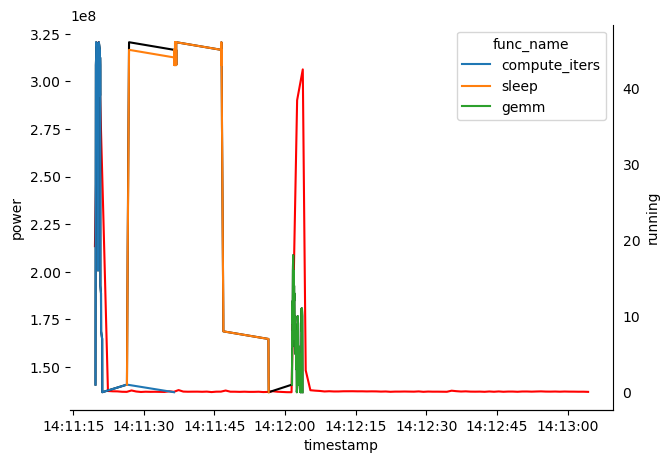

In [3]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(energy[1:], x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(status, x="timestamp", y="running", ax=ax2, color="black")
sns.lineplot(status, x="timestamp", y="running_per_task", ax=ax2, hue="func_name")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

In [29]:
resources = pd.read_sql(f"SELECT * FROM resource WHERE psutil_process_name='process_worker_'", conn)
resources["timestamp"] = pd.to_datetime(resources['timestamp'])
resources = resources.sort_values("timestamp", ignore_index=True)
resources = resources.loc[:,~resources.columns.str.startswith('psutil_process_')]
resources = resources.drop(["run_id"], axis=1)
resources

,pid,timestamp,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired
0,2764848,2023-08-16 14:11:19.445742,100471,101160,45,88664
1,2764848,2023-08-16 14:11:19.523420,4195384,4210080,1277,2573006
2,2764949,2023-08-16 14:11:19.524678,454,480,0,1
3,2764954,2023-08-16 14:11:19.525653,281416,281880,1253,178330
4,2764957,2023-08-16 14:11:19.527749,1198544,1215120,3277,1323512
...,...,...,...,...,...,...
5074,2765083,2023-08-16 14:13:04.367313,1488839199,1489633320,2538344,5043447079
5075,2765086,2023-08-16 14:13:04.367660,1306704419,1306987920,1718969,4545136857
5076,2765089,2023-08-16 14:13:04.367995,1316454260,1316974080,1730048,4542634225
5077,2765092,2023-08-16 14:13:04.368330,1353609762,1353998400,1675414,4719347111


In [30]:
def split(df):
    gb = df.groupby(['pid'])
    return [gb.get_group(x) for x in gb.groups]

df_split = split(resources)
df_split[0]

,pid,timestamp,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired
0,2764848,2023-08-16 14:11:19.445742,100471,101160,45,88664
1,2764848,2023-08-16 14:11:19.523420,4195384,4210080,1277,2573006
39,2764848,2023-08-16 14:11:20.358959,4195384,4210080,1277,2573006
87,2764848,2023-08-16 14:11:21.358022,4195384,4210080,1277,2573006
135,2764848,2023-08-16 14:11:22.354481,4195384,4210080,1277,2573006
...,...,...,...,...,...,...
4839,2764848,2023-08-16 14:13:00.352650,4195384,4210080,1277,2573006
4887,2764848,2023-08-16 14:13:01.351994,4195384,4210080,1277,2573006
4935,2764848,2023-08-16 14:13:02.353040,4195384,4210080,1277,2573006
4983,2764848,2023-08-16 14:13:03.352485,4195384,4210080,1277,2573006


In [31]:
df_split[1]

,pid,timestamp,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired
2,2764949,2023-08-16 14:11:19.524678,454,480,0,1
40,2764949,2023-08-16 14:11:20.359458,61330,61320,320,16532
88,2764949,2023-08-16 14:11:21.358560,114983,114960,640,33053
136,2764949,2023-08-16 14:11:22.354999,129937,129840,650,49570
184,2764949,2023-08-16 14:11:23.355913,146483,146400,661,66087
...,...,...,...,...,...,...
4840,2764949,2023-08-16 14:13:00.353151,2098061,2098680,3196,1668281
4888,2764949,2023-08-16 14:13:01.352497,2113367,2113920,3199,1684798
4936,2764949,2023-08-16 14:13:02.353541,2134396,2134920,3202,1701315
4984,2764949,2023-08-16 14:13:03.352999,2152356,2152920,3205,1717832


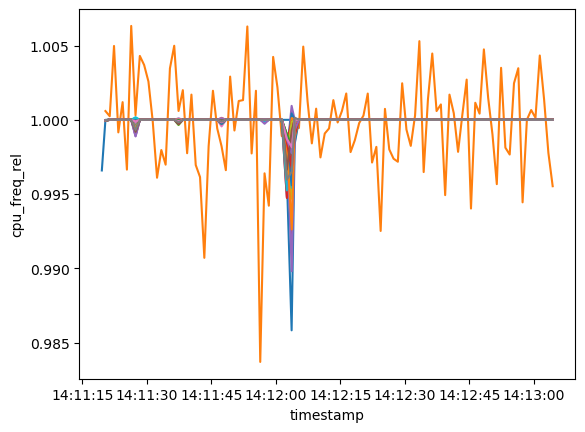

In [26]:
df_split_clean = []
for i in range(len(df_split)):
    df_new = df_split[i].diff()
    df_new["timestamp"] = (df_new["timestamp"] / np.timedelta64(1, "s"))
    df_new = df_new.div(df_new["timestamp"], axis='index')
    df_new["cpu_freq_rel"] = (df_new["perf_unhalted_core_cycles"] + .000001) / (df_new["perf_unhalted_reference_cycles"] + .000001) 
    df_new["pid"] = df_split[i]["pid"]
    df_new["timestamp"] = df_split[i]["timestamp"]
    df_new = df_new.set_index("timestamp")
    df_split_clean.append(df_new)
    sns.lineplot(df_split_clean[i], x="timestamp", y="cpu_freq_rel")

In [7]:
def sum_resources(df1, df2, columns=["perf_unhalted_core_cycles", "perf_unhalted_reference_cycles", "perf_llc_misses", "perf_instructions_retired", "cpu_freq_rel"]):
    df = pd.merge_asof(df1[columns], df2[columns], on="timestamp", direction="forward")
    for col in columns:
        df[col] = df[f"{col}_x"] + df[f"{col}_y"]
        df = df.drop([f"{col}_x", f"{col}_y"], axis=1)
    df = df.set_index("timestamp")
    return df

In [8]:
df = df_split_clean[0]
for i in range(1, len(df_split_clean)):
    df = sum_resources(df, df_split_clean[i])
df

,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired,cpu_freq_rel
timestamp,,,,,
2023-08-16 14:11:19.445742,NaN,NaN,NaN,NaN,NaN
2023-08-16 14:11:19.523420,NaN,NaN,NaN,NaN,NaN
2023-08-16 14:11:20.358959,NaN,NaN,NaN,NaN,NaN
2023-08-16 14:11:21.358022,6.167224e+10,6.167212e+10,623540.829442,2.297204e+11,48.000373
2023-08-16 14:11:22.354481,1.500744e+04,1.493318e+04,10.035737,1.657603e+04,48.004973
...,...,...,...,...,...
2023-08-16 14:13:00.352650,1.452505e+04,1.452305e+04,5.001050,1.652047e+04,48.000138
2023-08-16 14:13:01.351994,1.531602e+04,1.524997e+04,3.001963,1.652781e+04,48.004331
2023-08-16 14:13:02.353040,2.100707e+04,2.097810e+04,2.996871,1.649977e+04,48.001381


In [9]:
df_combined = pd.merge_asof(energy, df, on="timestamp", direction="backward")
df_combined

,run_id,block_id,hostname,timestamp,duration,total_energy,resource_monitoring_interval,devices,power,perf_unhalted_core_cycles,perf_unhalted_reference_cycles,perf_llc_misses,perf_instructions_retired,cpu_freq_rel
0,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:19.448261,0.751630,139968148.0,1.0,"{""package-0"": {""start_time"": 14594676.21849440...",1.862194e+08,NaN,NaN,NaN,NaN,NaN
1,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:19.607918,0.159898,34132541.0,1.0,"{""package-0"": {""start_time"": 14594676.97012474...",2.134648e+08,NaN,NaN,NaN,NaN,NaN
2,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:20.382190,0.774211,248121130.0,1.0,"{""package-0"": {""start_time"": 14594677.13002252...",3.204828e+08,NaN,NaN,NaN,NaN,NaN
3,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:21.377229,0.995156,229746422.0,1.0,"{""package-0"": {""start_time"": 14594677.90423304...",2.308647e+08,6.167224e+10,6.167212e+10,623540.829442,2.297204e+11,48.000373
4,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:11:22.372067,0.994878,136746415.0,1.0,"{""package-0"": {""start_time"": 14594678.89938909...",1.374504e+08,1.500744e+04,1.493318e+04,10.035737,1.657603e+04,48.004973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:00.370733,0.999685,137074600.0,1.0,"{""package-0"": {""start_time"": 14594776.89326373...",1.371177e+08,1.452505e+04,1.452305e+04,5.001050,1.652047e+04,48.000138
103,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:01.370115,0.999350,137018448.0,1.0,"{""package-0"": {""start_time"": 14594777.89294921...",1.371076e+08,1.531602e+04,1.524997e+04,3.001963,1.652781e+04,48.004331
104,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:02.371127,1.001051,137210891.0,1.0,"{""package-0"": {""start_time"": 14594778.89229901...",1.370669e+08,2.100707e+04,2.097810e+04,2.996871,1.649977e+04,48.001381
105,b8728c97-2107-470f-bc99-46b75493832c,0,midway3-0017.rcc.local,2023-08-16 14:13:03.370605,0.999468,137004593.0,1.0,"{""package-0"": {""start_time"": 14594779.89334974...",1.370775e+08,1.796974e+04,1.800976e+04,3.001627,1.652596e+04,47.997778


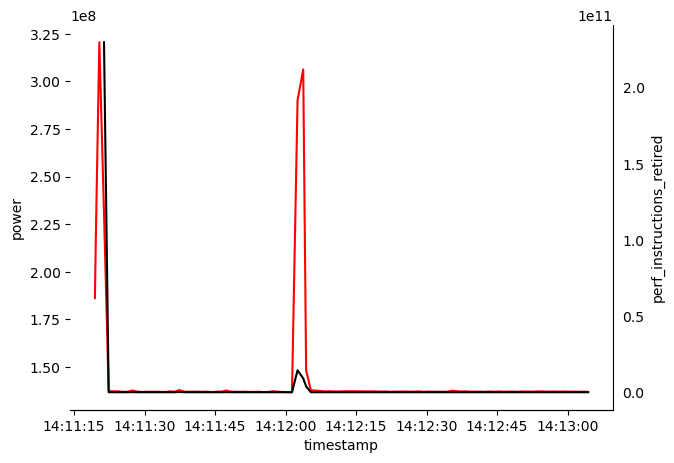

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="perf_instructions_retired", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

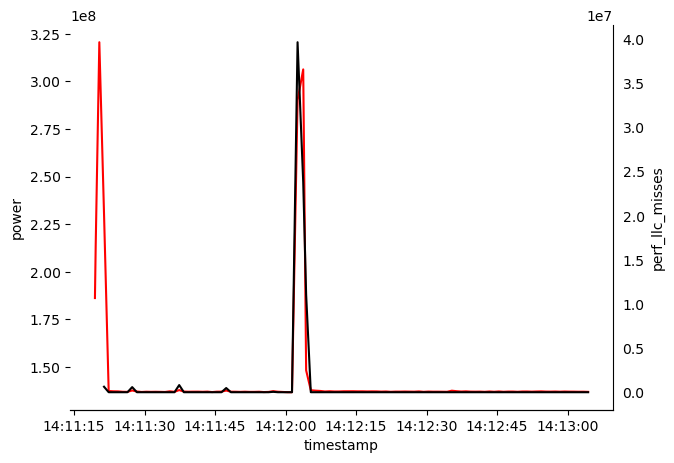

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="perf_llc_misses", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

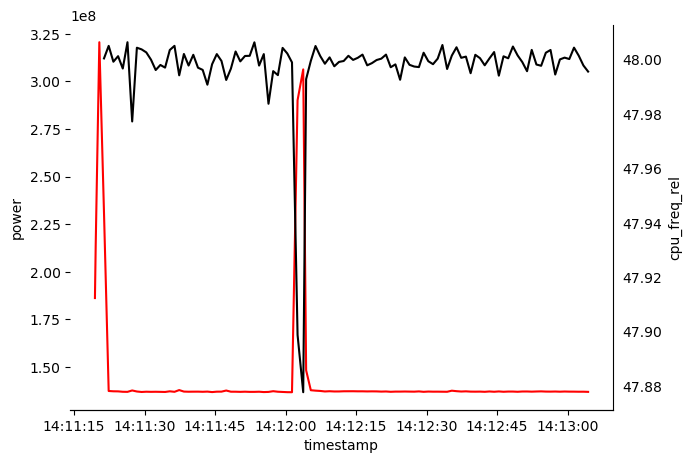

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="cpu_freq_rel", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

In [14]:
from sklearn.linear_model import ElasticNet

/mnt/d/UChicago/src/research/envs/funcx-dev/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e+15, tolerance: 5.911e+12
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_13875/1865131211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined["pred_power"] = regr.predict(df_combined[["perf_instructions_retired", "perf_llc_misses"]])


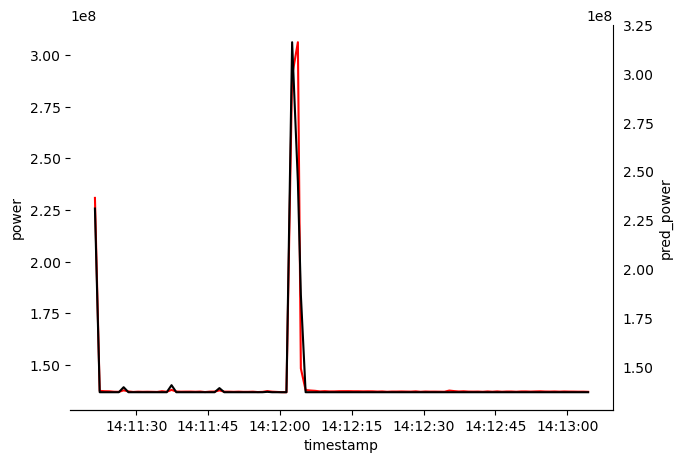

In [16]:
df_combined = df_combined.dropna()
regr = ElasticNet(random_state=0)
regr.fit(df_combined[["perf_instructions_retired", "perf_llc_misses"]], df_combined["power"])
df_combined["pred_power"] = regr.predict(df_combined[["perf_instructions_retired", "perf_llc_misses"]])

fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
ax2 = ax.twinx()
sns.lineplot(df_combined, x="timestamp", y="pred_power", ax=ax2, color="black")
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)

In [19]:
regr.intercept_

137045707.71042883

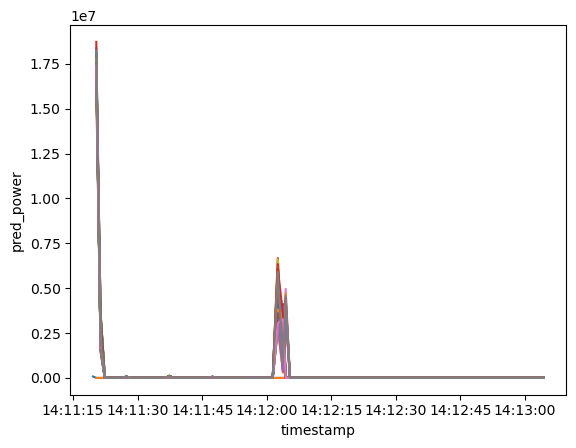

In [103]:
process_preds = {}
for i in range(len(df_split_clean)):
    worker_df = df_split_clean[i]
    worker_df = pd.merge_asof(energy, worker_df, on="timestamp", direction="backward").dropna()
    worker_df["pred_power"] = regr.predict(worker_df[["perf_instructions_retired", "perf_llc_misses"]]) - regr.intercept_
    sns.lineplot(worker_df, x="timestamp", y="pred_power")
    process_preds[worker_df["pid"].iloc[0]] = interpolate.interp1d(worker_df["timestamp"].view(int), worker_df["pred_power"])

,task_id,pid,func_name,task_try_time_running,task_try_time_running_ended,running_duration
0,d241d37e-12c2-4335-a127-f1b70817bbae,2764954,compute_iters,1692195079774261000,1692195080234726000,460465000
1,4e85f49b-da4e-43e9-9bd5-634182241fdb,2764957,compute_iters,1692195079727266000,1692195080189949000,462683000
2,0c8f6a11-8437-431b-9fb1-ac3bcb9c8722,2764960,compute_iters,1692195079742906000,1692195080203214000,460308000
3,4f8f989d-6a30-4854-9329-26fef8065e05,2764963,compute_iters,1692195079730761000,1692195080191634000,460873000
4,6a5f38b3-ec54-4a9a-9345-74aa062fc8f7,2764966,compute_iters,1692195079732795000,1692195080193082000,460287000
...,...,...,...,...,...,...
295,12049e19-986a-44c9-abe0-7481f4331adf,2765064,gemm,1692195123506809000,1692195123657124000,150315000
296,643f5dee-4730-48f1-99ef-0ac35af956d6,2765086,gemm,1692195123506698000,1692195123667797000,161099000
297,dc016121-6062-4c55-9c76-3608c982596e,2765043,gemm,1692195123579118000,1692195123686854000,107736000
298,68eabfc7-5b7a-4120-818b-1f09fac20645,2765002,gemm,1692195123579156000,1692195123671218000,92062000


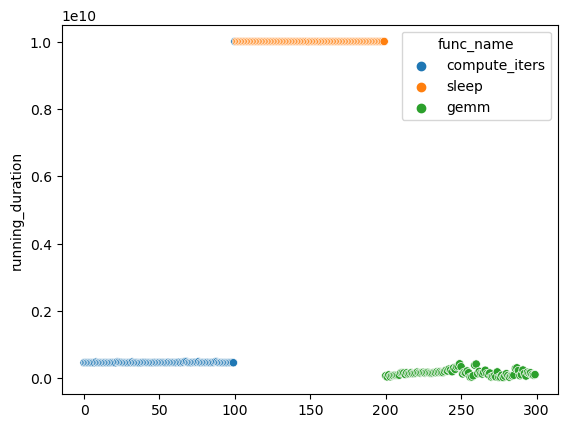

In [105]:
trys = pd.read_sql(f"SELECT task_id, pid FROM try ORDER BY task_try_time_launched", conn)
trys["func_name"] = "sleep"
trys.loc[:100, "func_name"] = "compute_iters"
trys.loc[200:, "func_name"] = "gemm"

start_times = pd.read_sql(f"SELECT task_id, timestamp FROM status WHERE (task_status_name='running')", conn)
trys = pd.merge(trys, start_times, on="task_id")
trys = trys.rename(columns={"timestamp": "task_try_time_running"})

end_times = pd.read_sql(f"SELECT task_id, timestamp FROM status WHERE (task_status_name='running_ended')", conn)
trys = pd.merge(trys, end_times, on="task_id")
trys = trys.rename(columns={"timestamp": "task_try_time_running_ended"})

trys["task_try_time_running"] = pd.to_datetime(trys['task_try_time_running']).view(int)
trys["task_try_time_running_ended"] = pd.to_datetime(trys['task_try_time_running_ended']).view(int)
trys["running_duration"] = trys["task_try_time_running_ended"] - trys["task_try_time_running"]
sns.scatterplot(data=trys, x=trys.index, y="running_duration", hue="func_name")
trys

<Axes: ylabel='energy'>

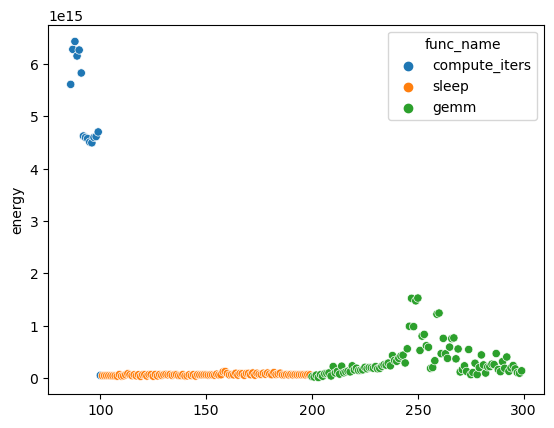

In [111]:
def calc_energy(row):
    try:
        x, _ = integrate.quad(process_preds[row[1]], row[3], row[4])
        return x
    except:
        return None

trys["energy"]  = trys.apply(calc_energy, axis=1)
sns.scatterplot(data=trys, x=trys.index, y="energy", hue="func_name")

In [123]:
def split(df):
    gb = df.groupby(['pid'])
    return [gb.get_group(x) for x in gb.groups]

def sum_resources(df1, df2, columns=["perf_unhalted_core_cycles", "perf_unhalted_reference_cycles", "perf_llc_misses", "perf_instructions_retired", "cpu_freq_rel"]):
    df = pd.merge_asof(df1[columns], df2[columns], on="timestamp", direction="forward")
    for col in columns:
        df[col] = df[f"{col}_x"] + df[f"{col}_y"]
        df = df.drop([f"{col}_x", f"{col}_y"], axis=1)
    df = df.set_index("timestamp")
    return df

def analyze_energy_consumption(database):
    engine = sqlalchemy.create_engine(database)
    conn = engine.connect()
    
    trys = pd.read_sql(f"SELECT task_id, block_id, task_try_time_launched FROM try ORDER BY task_try_time_launched", conn)
    trys["func_name"] = "sleep"
    trys.loc[1:101, "func_name"] = "compute_iters"
    trys.loc[201:, "func_name"] = "gemm"

    energy = pd.read_sql(f"SELECT * FROM energy", conn)
    energy["timestamp"] = pd.to_datetime(energy['timestamp'])
    energy["power"] = energy["total_energy"] / energy["duration"]
    energy = energy.sort_values("timestamp", ignore_index=True)
    
    resources = pd.read_sql(f"SELECT * FROM resource WHERE psutil_process_name='process_worker_'", conn)
    resources["timestamp"] = pd.to_datetime(resources['timestamp'])
    resources = resources.sort_values("timestamp", ignore_index=True)
    resources = resources.loc[:,~resources.columns.str.startswith('psutil_process_')]
    resources = resources.drop(["run_id"], axis=1)
    
    df_split = split(resources)
    df_split_clean = []
    for i in range(len(df_split)):
        df_new = df_split[i].diff()
        df_new["timestamp"] = (df_new["timestamp"] / np.timedelta64(1, "s"))
        df_new = df_new.div(df_new["timestamp"], axis='index')
        df_new["cpu_freq_rel"] = (df_new["perf_unhalted_core_cycles"] + .000001) / (df_new["perf_unhalted_reference_cycles"] + .000001) 
        df_new["pid"] = df_split[i]["pid"]
        df_new["timestamp"] = df_split[i]["timestamp"]
        df_new = df_new.set_index("timestamp")
        df_split_clean.append(df_new)
    
    df = df_split_clean[0]
    for i in range(1, len(df_split_clean)):
        df = sum_resources(df, df_split_clean[i])
    df_combined = pd.merge_asof(energy, df, on="timestamp", direction="backward")
    
    df_combined = df_combined.dropna()
    regr = ElasticNet(random_state=0, positive=True)
    regr.fit(df_combined[["perf_instructions_retired", "perf_llc_misses"]], df_combined["power"])
    df_combined["pred_power"] = regr.predict(df_combined[["perf_instructions_retired", "perf_llc_misses"]])

    fig, ax = plt.subplots(figsize=(7,5))
    sns.lineplot(df_combined, x="timestamp", y="power", ax=ax, color="red")
    sns.lineplot(df_combined, x="timestamp", y="pred_power", ax=ax, color="black")
    plt.show()
    
    process_preds = {}
    for i in range(len(df_split_clean)):
        worker_df = df_split_clean[i]
        worker_df = pd.merge_asof(energy, worker_df, on="timestamp", direction="backward").dropna()
        worker_df["pred_power"] = regr.predict(worker_df[["perf_instructions_retired", "perf_llc_misses"]]) - regr.intercept_
        process_preds[worker_df["pid"].iloc[0]] = interpolate.interp1d(worker_df["timestamp"].view(int), worker_df["pred_power"])
    
    trys = pd.read_sql(f"SELECT task_id, pid FROM try ORDER BY task_try_time_launched", conn)
    trys["func_name"] = "sleep"
    trys.loc[:100, "func_name"] = "compute_iters"
    trys.loc[200:, "func_name"] = "gemm"

    start_times = pd.read_sql(f"SELECT task_id, timestamp FROM status WHERE (task_status_name='running')", conn)
    trys = pd.merge(trys, start_times, on="task_id")
    trys = trys.rename(columns={"timestamp": "task_try_time_running"})

    end_times = pd.read_sql(f"SELECT task_id, timestamp FROM status WHERE (task_status_name='running_ended')", conn)
    trys = pd.merge(trys, end_times, on="task_id")
    trys = trys.rename(columns={"timestamp": "task_try_time_running_ended"})

    trys["task_try_time_running"] = pd.to_datetime(trys['task_try_time_running']).view(int)
    trys["task_try_time_running_ended"] = pd.to_datetime(trys['task_try_time_running_ended']).view(int)
    trys["running_duration"] = trys["task_try_time_running_ended"] - trys["task_try_time_running"]
    sns.scatterplot(data=trys, x=trys.index, y="running_duration", hue="func_name")
    plt.show()
    
    def calc_energy(row):
        try:
            x, _ = integrate.quad(process_preds[row[1]], row[3], row[4])
            return x
        except:
            return None

    trys["energy"]  = trys.apply(calc_energy, axis=1)
    sns.scatterplot(data=trys, x=trys.index, y="energy", hue="func_name")
    plt.show()
    
    sns.barplot(data=trys, x="func_name", y="energy")
    plt.show()
    return trys

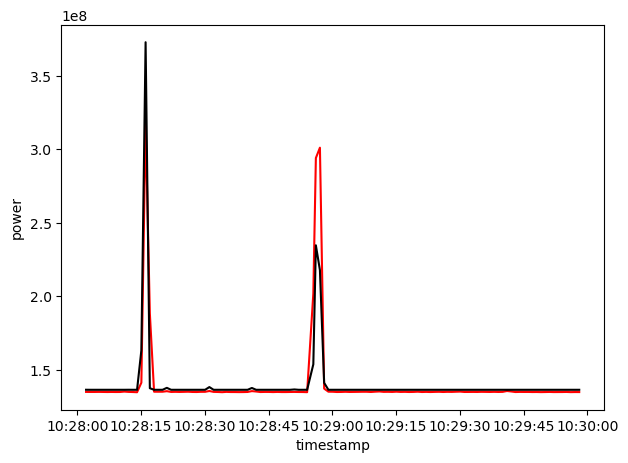

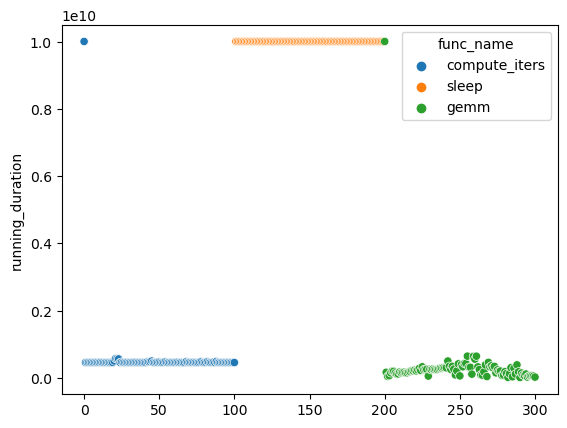

/tmp/ipykernel_13875/1492877836.py:88: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  x, _ = integrate.quad(process_preds[row[1]], row[3], row[4])


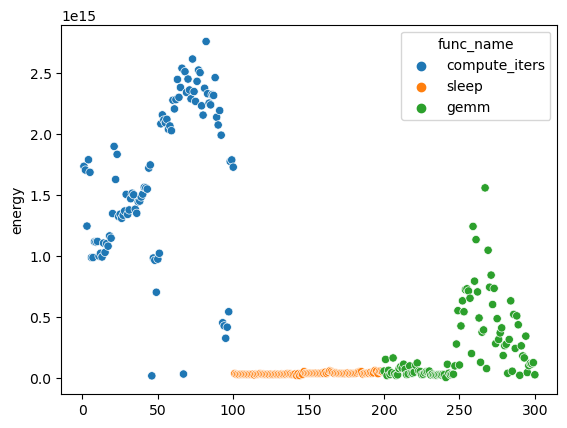

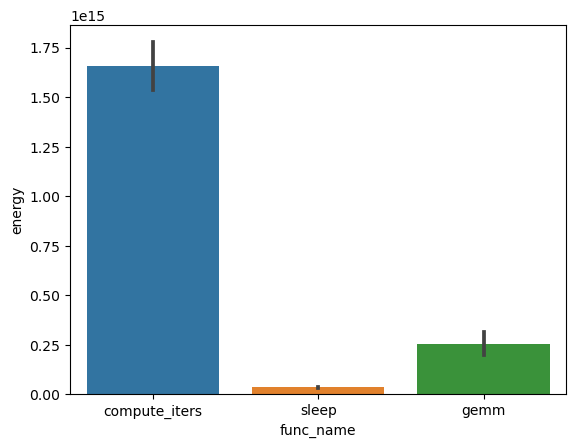

In [125]:
midway_energy_log = analyze_energy_consumption("sqlite:///midway_monitoring.db")
midway_energy_log["machine"] = "midway"

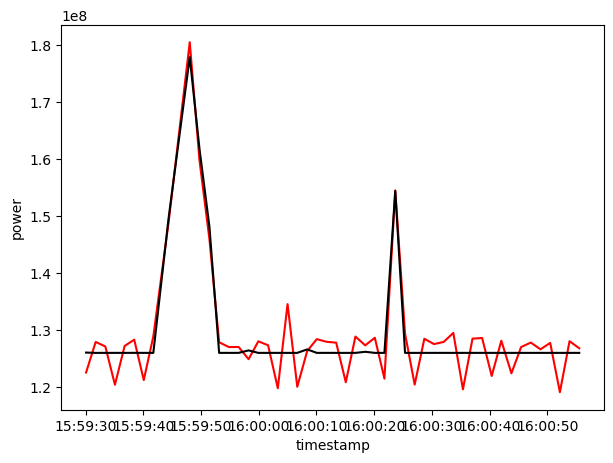

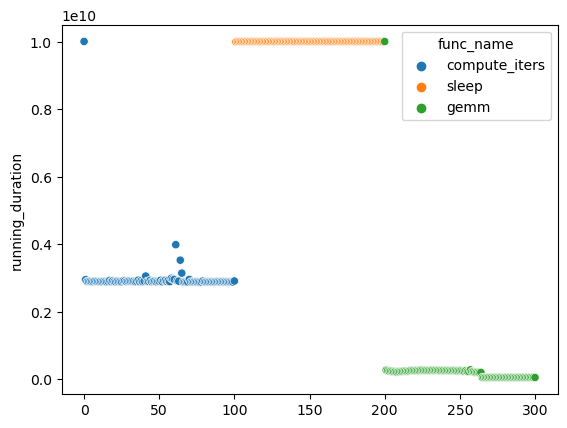

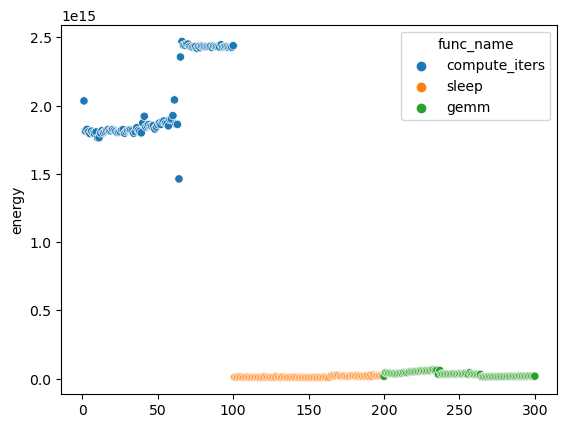

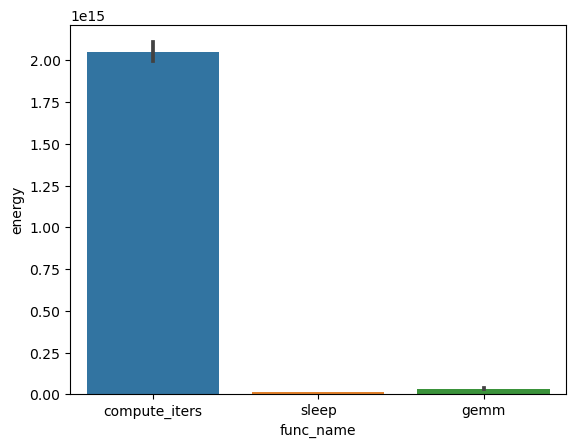

In [126]:
theta_energy_log = analyze_energy_consumption("sqlite:///theta_monitoring.db")
theta_energy_log["machine"] = "theta"

Text(0.5, 1.0, 'Energy Comparison Between Machines')

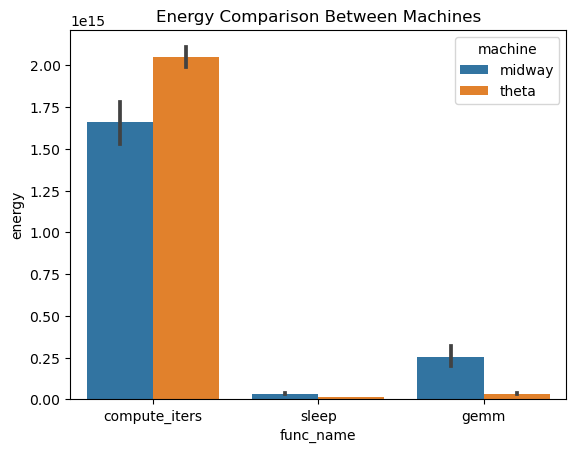

In [130]:
energy_log = pd.concat([midway_energy_log, theta_energy_log])
sns.barplot(data=energy_log, x="func_name", y="energy", hue="machine")
plt.title("Energy Comparison Between Machines")